# Sports Action Recognition Using a Video Vision Transformer Model with `UCF101 10 Sports actions`

## Dependencies

In [1]:
!pip install kagglehub --quiet

In [2]:
import os
import re
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, top_k_accuracy_score, classification_report, confusion_matrix

import imageio
import cv2
from IPython.display import Image

import tensorflow as tf  # for data preprocessing only
import keras
from keras import layers, ops, models, optimizers, losses, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.metrics import top_k_categorical_accuracy

import kagglehub

## Dataset Loading

Download latest version of the ucf101-action-recognition dataset from Kaggle

In [3]:
path = kagglehub.dataset_download("matthewjansen/ucf101-action-recognition")

In [4]:
print("Path to dataset files: \n", path)
print("\nFiles in dataset directory:\n", os.listdir(path))

Path to dataset files: 
 /Users/mzitoh/.cache/kagglehub/datasets/matthewjansen/ucf101-action-recognition/versions/4

Files in dataset directory:
 ['test', 'val.csv', 'test.csv', 'train', 'train.csv', 'val']


**Class Definition**

In [5]:
sports_actions = [
    "SkyDiving",
    "Biking",
    "HorseRace",
    "Surfing",
    "TennisSwing",
    "Punch",
    "Basketball",
    "JumpRope",
    "Archery",
    "Skiing",
]

Utility to transform video paths

In [6]:
def load_dataset(dataset_type):
    dataset_path = os.path.join(path, f"{dataset_type}.csv")
    dataset = pd.read_csv(dataset_path)

    # Filter dataset to only include the specified sports actions
    filtered_dataset = dataset[dataset["label"].isin(sports_actions)]

    return pd.DataFrame(
        {
            "label": filtered_dataset["label"],
            "video_name": filtered_dataset["clip_name"],
            "rel_path": filtered_dataset["clip_path"],
            "video_path": filtered_dataset["clip_path"].apply(lambda x: f"{path}{x}"),
        }
    )

Load the train and test datasets

In [7]:
train_df = load_dataset("train")
val_df = load_dataset("val")
test_df = load_dataset("test")


print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for validation: {len(val_df)}")
print(f"Total videos for testing: {len(test_df)}")

Total videos for training: 1128
Total videos for validation: 189
Total videos for testing: 192


In [8]:
print("Number of unique classes in training set: ", len(train_df["label"].unique()))
print("Number of unique classes in validation set: ", len(val_df["label"].unique()))
print("Number of unique classes in test set: ", len(test_df["label"].unique()))

print("\nLabels: \n", train_df["label"].unique())

Number of unique classes in training set:  10
Number of unique classes in validation set:  10
Number of unique classes in test set:  10

Labels: 
 ['SkyDiving' 'TennisSwing' 'Skiing' 'Punch' 'Archery' 'JumpRope'
 'Basketball' 'Biking' 'HorseRace' 'Surfing']


In [9]:
train_df.sample(10)

,label,video_name,rel_path,video_path
4491,JumpRope,v_JumpRope_g21_c02,/train/JumpRope/v_JumpRope_g21_c02.avi,/Users/mzitoh/.cache/kagglehub/datasets/matthe...
2889,Punch,v_Punch_g14_c06,/train/Punch/v_Punch_g14_c06.avi,/Users/mzitoh/.cache/kagglehub/datasets/matthe...
2959,Archery,v_Archery_g18_c03,/train/Archery/v_Archery_g18_c03.avi,/Users/mzitoh/.cache/kagglehub/datasets/matthe...
1860,Skiing,v_Skiing_g01_c02,/train/Skiing/v_Skiing_g01_c02.avi,/Users/mzitoh/.cache/kagglehub/datasets/matthe...
5176,Basketball,v_Basketball_g21_c03,/train/Basketball/v_Basketball_g21_c03.avi,/Users/mzitoh/.cache/kagglehub/datasets/matthe...
2859,Punch,v_Punch_g25_c07,/train/Punch/v_Punch_g25_c07.avi,/Users/mzitoh/.cache/kagglehub/datasets/matthe...
2849,Punch,v_Punch_g11_c06,/train/Punch/v_Punch_g11_c06.avi,/Users/mzitoh/.cache/kagglehub/datasets/matthe...
4413,JumpRope,v_JumpRope_g11_c05,/train/JumpRope/v_JumpRope_g11_c05.avi,/Users/mzitoh/.cache/kagglehub/datasets/matthe...
5140,Basketball,v_BasketballDunk_g23_c05,/train/Basketball/v_BasketballDunk_g23_c05.avi,/Users/mzitoh/.cache/kagglehub/datasets/matthe...
9022,HorseRace,v_HorseRace_g14_c01,/train/HorseRace/v_HorseRace_g14_c01.avi,/Users/mzitoh/.cache/kagglehub/datasets/matthe...


## Configs and Hyperparameters

Setting seed for reproducibility

In [10]:
SEED = 42 
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

keras.utils.set_random_seed(SEED)

In [11]:
# MODEL
MODEL_NAME = "transformer_ucf101_10c"
NUM_CLASSES = len(sports_actions)

# DATA
FRAME_SIZE = 224
FRAME_COUNT = 20
# FRAME_COUNT = 64 TODO: Change to 64 for final training
INPUT_SHAPE = (FRAME_COUNT, FRAME_SIZE, FRAME_SIZE, 3)  # (frames, height, width, channels) 32 X 224 X 224 X 3
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

# TRAINING
EPOCHS = 60
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 128
NUM_HEADS = 8 
NUM_LAYERS = 8

# TUBELET CONFIG
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) * (INPUT_SHAPE[1] // PATCH_SIZE[1]) * (INPUT_SHAPE[2] // PATCH_SIZE[2])
# = (32//8) * (224//8) * (224//8)
# = 4 * 28 * 28
# = 3,136 patches

Set path for model saving and retrieval

In [12]:
base_dir = "../../models"
pattern = re.compile(rf"{MODEL_NAME}_v(\d+)\.keras")

existing_versions = [
    int(pattern.search(f).group(1)) 
    for f in os.listdir(base_dir) if pattern.search(f)
]
version = max(existing_versions, default=0) + 1
MODEL_PATH = os.path.join(base_dir, f"{MODEL_NAME}_v{version}.keras")

print(f"Model will be saved to: '{MODEL_PATH}'")

Model will be saved to: '../../models/transformer_ucf101_10c_v1.keras'


## Video Data Preprocessing

#### Review video category distribution

In [13]:
def review_class_distribution(dataset, dataset_name):
    class_counts = dataset["label"].value_counts()
    return class_counts

Combined average number of videos per class:
             Train  Validation  Test  Average
label                                        
Archery        108          18    19       48
Basketball     198          33    34       88
Biking         100          17    17       45
HorseRace       93          15    16       41
JumpRope       108          18    18       48
Punch          120          20    20       53
Skiing         101          17    17       45
SkyDiving       82          14    14       37
Surfing         94          16    16       42
TennisSwing    124          21    21       55


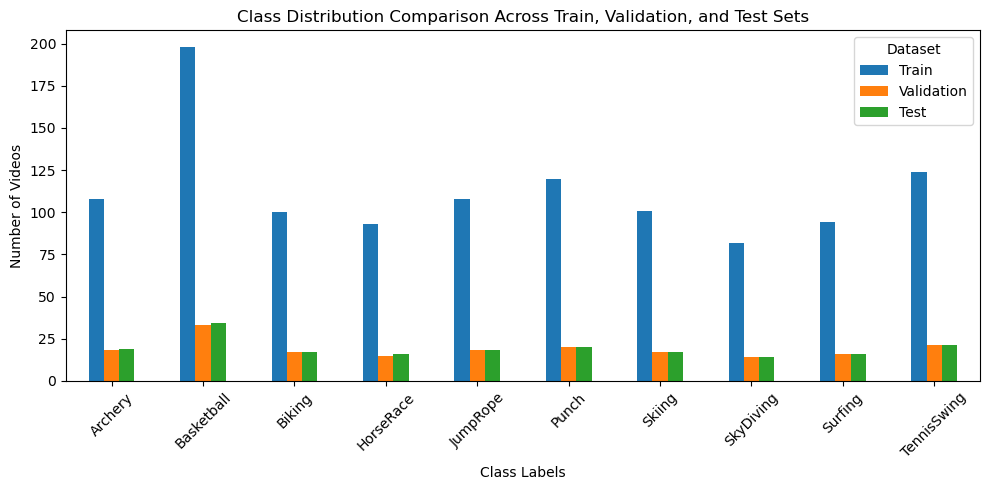

In [14]:
# Get class distributions for each dataset
train_class_counts = review_class_distribution(train_df, "Train")
val_class_counts = review_class_distribution(val_df, "Validation")
test_class_counts = review_class_distribution(test_df, "Test")

# Create DataFrame for distribution and calculate average
distribution_df = pd.DataFrame({
    "Train": train_class_counts,
    "Validation": val_class_counts,
    "Test": test_class_counts
}).fillna(0)

distribution_df["Average"] = distribution_df.mean(axis=1).round().astype(int)
print("Combined average number of videos per class:")
print(distribution_df)

# Plot the distribution
plot_distribution_df = distribution_df.drop(columns="Average")
plot_distribution_df.plot(kind="bar", figsize=(10, 5))
plt.title("Class Distribution Comparison Across Train, Validation, and Test Sets")
plt.xlabel("Class Labels")
plt.ylabel("Number of Videos")
plt.legend(title="Dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Review Video frame distribution 

Count the number of frames for each video

In [15]:
def count_frames_per_video(video_paths):
    frame_counts = []

    for video_path in video_paths: 
        cap = cv2.VideoCapture(video_path)
        count = 0
        
        if len(frame_counts) > 10:
            break
        
        while cap.isOpened():
            ret, _ = cap.read()
            if not ret:
                break
            count += 1
        cap.release()
        frame_counts.append(count)

    return frame_counts

In [16]:
def visualize_frame_distribution(frame_counts):
    plt.figure(figsize=(8, 5))
    sns.violinplot(x=frame_counts)
    plt.title("Violin Plot of Frame Counts per Video")
    plt.xlabel("Number of Frames")
    plt.xlabel("Number of Frames")
    plt.show()

In [17]:
frame_counts = count_frames_per_video(train_df["video_path"].values)

Standard deviation of the frame counts

In [18]:
np.std(frame_counts)

36.023867203070566

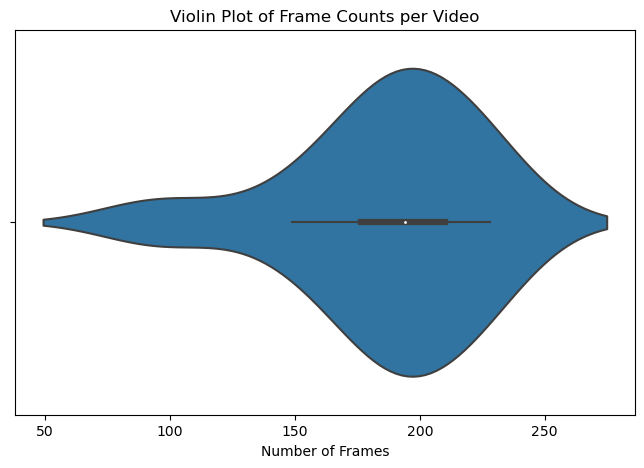

In [19]:
visualize_frame_distribution(frame_counts)

#### Video preprocessing utilities

 Function to resize the video frames to a square shape without distorting their content

In [20]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]  # Get the height (y) and width (x) of the image
    min_dim = min(y, x)       # Find the smallest dimension (either height or width)
    start_x = (x // 2) - (min_dim // 2)  # Calculate the horizontal starting point for the crop
    start_y = (y // 2) - (min_dim // 2)  # Calculate the vertical starting point for the crop
    
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]  # Return the cropped square

Crop,resize, and reorder color channels

In [21]:
def load_and_preprocess_video(video_path, max_frames=FRAME_COUNT, resize=(FRAME_SIZE, FRAME_SIZE)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]] # Reorder the color channels from OpenCV BGR to RGB
            
            # Normalize pixel values to the range [0, 1] and convert to float32 for TensorFlow
            frame = frame.astype(np.float32) / 255.0
            
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()

    frames = np.array(frames)
    
    if frames.shape[0] < max_frames:
        # Create zero padding for frames with shape (max_frames - current_frame_count, height, width, channels)
        padding = np.zeros((max_frames - frames.shape[0], *frames.shape[1:]), dtype=np.float32)
        frames = np.concatenate([frames, padding], axis=0)

    frames_tensor = tf.convert_to_tensor(frames)

    # Create mask to indicate valid frames (1 for valid, 0 for padding)
    mask = tf.cast(tf.sequence_mask([frames.shape[0]], max_frames), tf.float32)

    return frames_tensor, mask

Encode the class labels as integers using the Keras StringLookup layer

In [22]:
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=sports_actions)

class_vocab = label_processor.get_vocabulary()

print(f"Vocabulary: {class_vocab}")
print(f"Number of classes: {len(class_vocab)}")

Vocabulary: ['SkyDiving', 'Biking', 'HorseRace', 'Surfing', 'TennisSwing', 'Punch', 'Basketball', 'JumpRope', 'Archery', 'Skiing']
Number of classes: 10


Load all the videos from a dataset

In [23]:
def load_videos(dataset, dataset_type):
    start_time = time.time()

    video_frames = []
    masks = []
    labels = keras.ops.convert_to_numpy(label_processor(dataset["label"].values[..., None]))

    for _, row in dataset.iterrows():
        video_path = row["video_path"]

        frames, mask = load_and_preprocess_video(
            video_path, max_frames=FRAME_COUNT, resize=(FRAME_SIZE, FRAME_SIZE)
        )

        video_frames.append(frames)
        masks.append(mask)

    # Convert lists to NumPy arrays first to ensure consistency in shape
    video_frames = np.array(video_frames)
    labels = np.array(labels)
    masks = np.array(masks)

    # Convert to TensorFlow tensors
    video_frames = tf.convert_to_tensor(video_frames, dtype=tf.float32)
    labels = tf.convert_to_tensor(labels, dtype=tf.float32)
    masks = tf.convert_to_tensor(masks, dtype=tf.float32)

    end_time = time.time()
    elapsed_time = end_time - start_time
    time_unit = "seconds" if elapsed_time < 60 else "minutes"
    time_value = elapsed_time if elapsed_time < 60 else elapsed_time / 60
    print(f"Processed {len(video_frames)} {dataset_type} videos in {time_value:.2f} {time_unit}")

    return video_frames, masks, labels

#### Loading the preprocessed video frames

Extract the frame features, feature masks and labels for the `train` set

In [24]:
train_data, train_masks, train_labels = load_videos(train_df, "Train")

Processed 1128 Train videos in 1.80 minutes


Extract the frame features, feature masks and labels for the `validation` set

In [25]:
val_data, val_masks, val_labels = load_videos(val_df, "Validation")

Processed 189 Validation videos in 3.71 seconds


Extract the frame features, feature masks and labels for the `test` set

In [26]:
test_data, test_masks, test_labels = load_videos(test_df, "Test")

Processed 192 Test videos in 5.06 seconds


In [27]:
train_data.shape

TensorShape([1128, 20, 224, 224, 3])

In [28]:
train_masks.shape

TensorShape([1128, 1, 20])

In [29]:
total_samples, frame_count, _, _, _ = train_data.shape

print(f"""Video frames in train set: {train_data.shape} 
    → {total_samples} samples
    → {frame_count} frames per video
    → {FRAME_SIZE}x{FRAME_SIZE} resolution
    → {3} channels
""")

total_samples, _, mask_count = train_masks.shape
print(f"""Frame masks in train set: {train_data.shape} 
    → {total_samples} samples
    → {mask_count} masks per video
""")

print(f"Video frames in validation set: {val_data.shape}")
print(f"Frame masks in validation set: {val_data.shape}")

print(f"\nVideo frames in test set: {test_data.shape}")
print(f"Frame masks in test set: {test_data.shape}")

Video frames in train set: (1128, 20, 224, 224, 3) 
    → 1128 samples
    → 20 frames per video
    → 224x224 resolution
    → 3 channels

Frame masks in train set: (1128, 20, 224, 224, 3) 
    → 1128 samples
    → 20 masks per video

Video frames in validation set: (189, 20, 224, 224, 3)
Frame masks in validation set: (189, 20, 224, 224, 3)

Video frames in test set: (192, 20, 224, 224, 3)
Frame masks in test set: (192, 20, 224, 224, 3)


#### Preparing the dataloader

In [30]:
def prepare_dataloader(
    videos: tf.Tensor,
    labels: tf.Tensor,
    masks: tf.Tensor,
    loader_type: str = "train",
):
    dataset = tf.data.Dataset.from_tensor_slices((videos, labels, masks))

    if loader_type == "train":
        dataset = dataset.shuffle(BATCH_SIZE * 2)

    dataloader = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return dataloader

In [31]:
train_loader = prepare_dataloader(train_data, train_labels, train_masks, loader_type="train")
val_loader = prepare_dataloader(val_data, val_labels, val_masks, loader_type="val")
test_dataloader = prepare_dataloader(test_data, test_labels, test_masks, loader_type="test")

## Video Vision Transformer(ViVit) Model Architecture

#### Tubelet Embedding
- Capturing Temporal Information by Extracting and Flattening Video Volumes

In [32]:
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches

#### Positional Embedding
- This layer adds positional information to the encoded video tokens

In [33]:
class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = ops.arange(0, num_tokens, 1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens

#### Spatio-temporal attention model

In [34]:
def create_vivit_classifier(tubelet_embedder, positional_encoder):
    inputs = layers.Input(shape=INPUT_SHAPE)
    patches = tubelet_embedder(inputs)
    encoded_patches = positional_encoder(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(NUM_LAYERS):
        # Layer normalization and MHSA
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=NUM_HEADS, key_dim=PROJECTION_DIM // NUM_HEADS, dropout=0.1
        )(x1, x1)

        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization and MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = keras.Sequential(
            [
                layers.Dense(units=PROJECTION_DIM * 4, activation=ops.gelu),
                layers.Dense(units=PROJECTION_DIM, activation=ops.gelu),
            ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization and Global average pooling.
    representation = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify outputs
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(representation)

    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

Model compilation

In [35]:
def compile_transformer_model(show_summary=True):
    tubelet_embedder = TubeletEmbedding(embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE)
    positional_encoder = PositionalEncoder(embed_dim=PROJECTION_DIM)

    model = create_vivit_classifier(tubelet_embedder, positional_encoder)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss="sparse_categorical_crossentropy",
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    if show_summary:
        model.summary()

    return model

In [36]:
transformer_model = compile_transformer_model(True)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 20, 224,   │          0 │ -                 │
│ (InputLayer)        │ 224, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tubelet_embedding   │ (None, 1568, 128) │    196,736 │ input_layer[0][0] │
│ (TubeletEmbedding)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoder  │ (None, 1568, 128) │    200,704 │ tubelet_embeddin… │
│ (PositionalEncoder) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 1568, 128) │        256 │ positional_encod… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1568, 128) │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1568, 128) │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1568, 128) │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 1568, 128) │    131,712 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1568, 128) │          0 │ sequential[0][0], │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1568, 128) │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1568, 128) │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 1568, 128) │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1568, 128) │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 1568, 128) │    131,712 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 1568, 128) │          0 │ sequential_1[0][… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1568, 128) │        256 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1568, 128) │     66,048 │ layer_normalizat

 Total params: 1,985,162 (7.57 MB)

 Trainable params: 1,985,162 (7.57 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [ ]:
def train_model(model, epochs=EPOCHS):
    checkpoint = ModelCheckpoint(
        MODEL_PATH,
        monitor="val_loss",
        mode="min",  # Save the model when the loss decreases (when model improves)
        save_weights_only=False,
        save_best_only=True,
        verbose=1,
    )

    # TODO: Experiment with this
    early_stopping = EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
    )

    history = model.fit(
        train_loader,
        epochs=epochs,
        validation_data=val_loader,
        callbacks=[checkpoint, early_stopping],
    )

    return history

: 

Start the training

In [ ]:
history = train_model(transformer_model, epochs=5)

Epoch 1/5


In [ ]:
if os.path.exists(MODEL_PATH):
    print(f"Model saved at: {MODEL_PATH}")
    model_size = os.path.getsize(MODEL_PATH) / (1024 * 1024)
    print(f"Model size: {model_size:.2f} MB")
else:
    print("Model file not found.")

Visualise the training and validation loss and accuracy

In [ ]:
def visualize_training_metrics(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    plt.figure(figsize=(12, 6))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.show()

In [ ]:
visualize_training_metrics(history)

## Model Testing & Evaluation

#### Evaluate model on the test data set

In [ ]:
def evaluate_model(model, test_loader):
    print("\nEvaluating the model on the test set...")
    model.load_weights(MODEL_PATH)

    _, accuracy, top_5_accuracy = model.evaluate(test_loader)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

In [ ]:
def evaluate_model(model, test_loader): 
    model.load_weights(MODEL_PATH)

    _, accuracy, top_5_accuracy = model.evaluate(test_loader)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

In [ ]:
evaluate_model(transformer_model, test_dataloader)

#### Evaluation with single video

Make predictions on a single video

In [ ]:
def sequence_prediction(model, vide_frames, video_mask, true_label):
    probabilities = model.predict([vide_frames, video_mask])[0]
        
    print("\nTop-5 actions:")
    for i in np.argsort(probabilities)[::-1][:5]:
        print(f"  - {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    
    # Get the top-1 predicted label (highest probability)
    predicted_index = np.argmax(probabilities)
    predicted_label = class_vocab[predicted_index]

    # Convert true_label to index to align with predicted index format
    true_label_index = class_vocab.index(true_label)

    # Prepare y_true and y_pred as binary arrays (1 for correct label, 0 for others)
    y_true = np.zeros(len(class_vocab))
    y_pred = np.zeros(len(class_vocab))
    y_true[true_label_index] = 1
    y_pred[predicted_index] = 1
 
    return y_true, y_pred, predicted_label

Display predicted image as GIF

In [ ]:
def display_as_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, duration=100)
    return Image("animation.gif")

Choosing a random video to use for prediction

In [ ]:
random_index = np.random.randint(len(test_data))

# Get the test video path
test_video_path = test_data["video_path"].values[random_index]

# Get the true label of the test video
true_label_index = test_labels.tolist()[random_index][0]
true_label = class_vocab[true_label_index]

test_video_frames, test_video_mask = load_and_preprocess_video(test_video_path)

print(f"Test video path: {test_video_path}")
print(f"Label: {true_label}")

print(f"""
Test video frames shape:
  - {test_video_frames.shape[0]} frames
  - {test_video_frames.shape[1]} pixels (height) x {test_video_frames.shape[2]} pixels (width)
  - {test_video_frames.shape[3]} color channels
""")

display_as_gif(test_video_frames[:FRAME_COUNT])

Run the prediction on the test video

In [ ]:
y_true, y_pred, predicted_label = sequence_prediction(
    transformer_model, test_video_frames, test_video_mask, true_label
)

In [ ]:
print(f"\nTrue label: {true_label}")
print(f"Predicted label: {predicted_label}")

print(f"y_true: {y_true}")
print(f"y_pred: {y_pred}")

#### Evaluation on the entire test set

Evaluation Metrics

In [ ]:
def display_evaluation_metrics(y_true, y_pred, predictions, target_classes):
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Top-1 Accuracy: {accuracy * 100:.2f}%")

    k = 2
    top_k_acc = top_k_accuracy_score(y_true, predictions, k=k)
    print(f"Top-{k} Accuracy: {top_k_acc * 100:.2f}%")

    report = classification_report(y_true, y_pred, target_names=target_classes, zero_division=0)
    print("\nClassification Report:\n", report)

In [ ]:
predictions = transformer_model.predict([test_data, test_masks], batch_size=BATCH_SIZE)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
display_evaluation_metrics(test_labels, predicted_classes, predictions, class_vocab)

In [ ]:
def display_confusion_matrix(y_true, y_pred, target_classes, show_plot=False):
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    if show_plot:
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, fmt="d", xticklabels=target_classes, yticklabels=target_classes)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.show()
    else:
        print(conf_matrix)

In [ ]:
true_labels = np.array(test_labels).flatten()
display_confusion_matrix(true_labels, predicted_classes, class_vocab, show_plot=True)

## References

> Minimal Implementations, "Hyperparameter Tuning Analysis," WandB. [Online]. Available: https://wandb.ai/minimal-implementations/vivit/reports/Hyperparameter-Tuning-Analysis--VmlldzoxNDEwNzcx